In [1]:
!pip install transformers
!pip install --user openpyxl==3.0.0

In [2]:
import os
import re
import string
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup
import transformers
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, AutoTokenizer, BertModel, BertConfig, AutoModel, AdamW

pd.set_option("display.max_columns", None)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_excel("/content/drive/My Drive/pleiade/shortEditionPosts.xlsx")

## Data formating

Pour le moment on enlève la catégorie "pas de catégorie", vraiment pertinent ? Est-ce que c'est bien fait ?

In [5]:
#df = pd.read_excel("shortEditionPosts.xlsx")

df = df.loc[:, ['genres', 'post']]

df.head()

,genres,post
0,['Horreur'],Les poissons avaient cessé de mordre d'un seul...
1,"['Instant de vie', 'Arts']","Quand on y entre, on aurait presque envie, d'a..."
2,"['Instant de vie', 'Drame']","Du plat de la main, Achille caressa les cambru..."
3,"['Instant de vie', 'Société']",La plupart des gens ont une vie où l'on ne voi...
4,"['Instant de vie', 'Humour']",Sonia adore ces soirées où elle invite des gen...


In [6]:
df.shape

(5770, 2)

In [7]:
def getGenres(entry):
    genres = entry[1:-1]
    genres = genres.replace("'", "")
    return genres.split(', ')

df["genres"] = df["genres"].apply(getGenres)


In [8]:
df.head()

,genres,post
0,[Horreur],Les poissons avaient cessé de mordre d'un seul...
1,"[Instant de vie, Arts]","Quand on y entre, on aurait presque envie, d'a..."
2,"[Instant de vie, Drame]","Du plat de la main, Achille caressa les cambru..."
3,"[Instant de vie, Société]",La plupart des gens ont une vie où l'on ne voi...
4,"[Instant de vie, Humour]",Sonia adore ces soirées où elle invite des gen...


In [9]:
categories = {}

for idx, entry in df.iterrows():
    for genre in entry["genres"]:
        if(genre in categories):
            categories[genre]+=1
        else:
            categories[genre]=0
            
del categories[""]
print(categories)

{'Horreur': 41, 'Instant de vie': 3404, 'Arts': 347, 'Drame': 1130, 'Société': 900, 'Humour': 606, 'Contes philosophiques': 54, 'Nature': 446, 'Famille': 845, 'Fantaisiste': 236, 'Personnification': 152, 'Surnaturel': 162, 'Policier': 48, 'Amitié': 228, 'Romance': 752, 'Spiritualité': 87, 'Érotisme': 48, 'Histoire': 191, 'Science-Fiction': 180, 'Contes merveilleux': 113, 'Thriller': 71, 'Fantasy': 19, 'Aventure': 99, 'Suspense': 420, 'Young Adult - Littérature générale': 4, 'Lettre': 41, 'Young Adult - Imaginaire': 4, 'Merveilleux': 72}


In [10]:
len(categories)

28

In [11]:
mlb = MultiLabelBinarizer()
df_new = pd.DataFrame(mlb.fit_transform(df['genres']),columns=mlb.classes_)
df_new["post"] = df["post"]
df_new

,,Amitié,Arts,Aventure,Contes merveilleux,Contes philosophiques,Drame,Famille,Fantaisiste,Fantasy,Histoire,Horreur,Humour,Instant de vie,Lettre,Merveilleux,Nature,Personnification,Policier,Romance,Science-Fiction,Société,Spiritualité,Surnaturel,Suspense,Thriller,Young Adult - Imaginaire,Young Adult - Littérature générale,Érotisme,post
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Les poissons avaient cessé de mordre d'un seul...
1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Quand on y entre, on aurait presque envie, d'a..."
2,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Du plat de la main, Achille caressa les cambru..."
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,La plupart des gens ont une vie où l'on ne voi...
4,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Sonia adore ces soirées où elle invite des gen...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5765,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,"Trois ballons. Un rouge, un vert, un orange.\n..."
5766,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,Regardez un immense champ vert... Un champ ple...
5767,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Ce matin, je me lève avec un poids insoutenabl..."
5768,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Madame se mit à jouer du piano. Ses doigts cou...


In [12]:
df_new = df_new[df_new[""] == 0]
df = df_new.reset_index().drop(["index", ""], axis=1)
df

,Amitié,Arts,Aventure,Contes merveilleux,Contes philosophiques,Drame,Famille,Fantaisiste,Fantasy,Histoire,Horreur,Humour,Instant de vie,Lettre,Merveilleux,Nature,Personnification,Policier,Romance,Science-Fiction,Société,Spiritualité,Surnaturel,Suspense,Thriller,Young Adult - Imaginaire,Young Adult - Littérature générale,Érotisme,post
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Les poissons avaient cessé de mordre d'un seul...
1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Quand on y entre, on aurait presque envie, d'a..."
2,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Du plat de la main, Achille caressa les cambru..."
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,La plupart des gens ont une vie où l'on ne voi...
4,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Sonia adore ces soirées où elle invite des gen...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5615,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,"Trois ballons. Un rouge, un vert, un orange.\n..."
5616,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,Regardez un immense champ vert... Un champ ple...
5617,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Ce matin, je me lève avec un poids insoutenabl..."
5618,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Madame se mit à jouer du piano. Ses doigts cou...


# Data visualization


<BarContainer object of 28 artists>

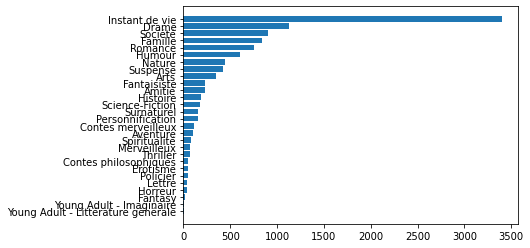

In [13]:
from matplotlib import pyplot as plt

items = categories.items()
items = sorted(items, key=lambda x: x[1])

names = list(map(lambda x: x[0], items))
values = list(map(lambda x: x[1], items))

plt.barh(range(len(values)), values, tick_label=names)

We can see that the different labels are not at all uniformly distributed, we will have to take that into account in our model

In [14]:
print(items)

[('Young Adult - Littérature générale', 4), ('Young Adult - Imaginaire', 4), ('Fantasy', 19), ('Horreur', 41), ('Lettre', 41), ('Policier', 48), ('Érotisme', 48), ('Contes philosophiques', 54), ('Thriller', 71), ('Merveilleux', 72), ('Spiritualité', 87), ('Aventure', 99), ('Contes merveilleux', 113), ('Personnification', 152), ('Surnaturel', 162), ('Science-Fiction', 180), ('Histoire', 191), ('Amitié', 228), ('Fantaisiste', 236), ('Arts', 347), ('Suspense', 420), ('Nature', 446), ('Humour', 606), ('Romance', 752), ('Famille', 845), ('Société', 900), ('Drame', 1130), ('Instant de vie', 3404)]


We will not take into account classes that are present less than a hundred times.

In [15]:
to_cut = [item[0] for item in items if item[1] < 100]

In [16]:
to_cut

['Young Adult - Littérature générale',
 'Young Adult - Imaginaire',
 'Fantasy',
 'Horreur',
 'Lettre',
 'Policier',
 'Érotisme',
 'Contes philosophiques',
 'Thriller',
 'Merveilleux',
 'Spiritualité',
 'Aventure']

In [17]:
df = df.drop(to_cut, axis = 1)
df.head()

,Amitié,Arts,Contes merveilleux,Drame,Famille,Fantaisiste,Histoire,Humour,Instant de vie,Nature,Personnification,Romance,Science-Fiction,Société,Surnaturel,Suspense,post
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Les poissons avaient cessé de mordre d'un seul...
1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,"Quand on y entre, on aurait presque envie, d'a..."
2,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,"Du plat de la main, Achille caressa les cambru..."
3,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,La plupart des gens ont une vie où l'on ne voi...
4,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,Sonia adore ces soirées où elle invite des gen...


Now, we filter out the entries that no longer have any label.

In [18]:
new_categories_count = [category for category in items if not(category[0] in to_cut)]
new_categories = [category[0] for category in new_categories_count]

In [19]:
print(new_categories_count)
print(new_categories)

[('Contes merveilleux', 113), ('Personnification', 152), ('Surnaturel', 162), ('Science-Fiction', 180), ('Histoire', 191), ('Amitié', 228), ('Fantaisiste', 236), ('Arts', 347), ('Suspense', 420), ('Nature', 446), ('Humour', 606), ('Romance', 752), ('Famille', 845), ('Société', 900), ('Drame', 1130), ('Instant de vie', 3404)]
['Contes merveilleux', 'Personnification', 'Surnaturel', 'Science-Fiction', 'Histoire', 'Amitié', 'Fantaisiste', 'Arts', 'Suspense', 'Nature', 'Humour', 'Romance', 'Famille', 'Société', 'Drame', 'Instant de vie']


In [20]:
df = df.loc[~(df[new_categories]==0).all(axis=1)]

In [21]:
df

,Amitié,Arts,Contes merveilleux,Drame,Famille,Fantaisiste,Histoire,Humour,Instant de vie,Nature,Personnification,Romance,Science-Fiction,Société,Surnaturel,Suspense,post
1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,"Quand on y entre, on aurait presque envie, d'a..."
2,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,"Du plat de la main, Achille caressa les cambru..."
3,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,La plupart des gens ont une vie où l'on ne voi...
4,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,Sonia adore ces soirées où elle invite des gen...
5,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,"Ce n'est pas que Germaine était jolie, mais il..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5615,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,"Trois ballons. Un rouge, un vert, un orange.\n..."
5616,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,Regardez un immense champ vert... Un champ ple...
5617,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,"Ce matin, je me lève avec un poids insoutenabl..."
5618,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,Madame se mit à jouer du piano. Ses doigts cou...


<BarContainer object of 16 artists>

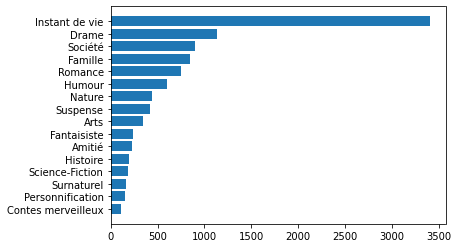

In [22]:
values = [category[1] for category in new_categories_count]

plt.barh(range(len(values)), values, tick_label=new_categories)

# Train/test split

In [23]:
train_df, val_df = train_test_split(df, test_size=0.2)

In [24]:
train_df.shape, val_df.shape

((4395, 17), (1099, 17))

## Model

In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [42]:
print(device)

cpu


In [27]:
# Sections of config

# Defining some key variables that will be used later on in the training
MAX_LEN = 200
TRAIN_BATCH_SIZE = 64
VALID_BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 2e-5
tokenizer = AutoTokenizer.from_pretrained('camembert-base')

Downloading:   0%|          | 0.00/508 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.33M [00:00<?, ?B/s]

In [28]:
#target_cols = [col for col in train_df.columns if col not in ['post']]
target_cols = new_categories

In [29]:
nb_classes = len(target_cols)

In [30]:
target_cols

['Contes merveilleux',
 'Personnification',
 'Surnaturel',
 'Science-Fiction',
 'Histoire',
 'Amitié',
 'Fantaisiste',
 'Arts',
 'Suspense',
 'Nature',
 'Humour',
 'Romance',
 'Famille',
 'Société',
 'Drame',
 'Instant de vie']

In [31]:
class BERTDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.max_len = max_len
        self.text = df.post
        self.tokenizer = tokenizer
        self.targets = df[target_cols].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text.iloc[index]
        inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]
        
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [32]:
train_dataset = BERTDataset(train_df, tokenizer, MAX_LEN)
valid_dataset = BERTDataset(val_df, tokenizer, MAX_LEN)

In [33]:
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, 
                          num_workers=2, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=VALID_BATCH_SIZE, 
                          num_workers=2, shuffle=False, pin_memory=True)

In [34]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.roberta = AutoModel.from_pretrained('camembert-base')
        for param in self.roberta.parameters():
          param.requires_grad=False
        self.lin1 = torch.nn.Linear(768,768)
        self.dropout = torch.nn.Dropout(0.3)
        self.lin2 = torch.nn.Linear(768, nb_classes)
    
    def forward(self, ids, mask, token_type_ids):
        _, features = self.roberta(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
#         output_2 = self.l2(output_1)
        output = F.relu(self.lin1(features))
        output = self.dropout(output)
        output = self.lin2(output)
        return output

model = BERTClass()
model.to(device);

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [35]:
pos_weight = np.array(train_df[target_cols].sum(), dtype=np.float)
pos_weight /= train_df.shape[0]
pos_weight = torch.tensor(pos_weight)
pos_weight = pos_weight.to(device)

In [36]:
"""
pos_weight = np.zeros(nb_classes)
            
del categories[""]
print(categories)

for i, item in enumerate(categories.items()):
  pos_weight[i] = item[1]/5770

pos_weight = torch.tensor(pos_weight)
pos_weight = pos_weight.to(device)
print(pos_weight)
"""

'\npos_weight = np.zeros(nb_classes)\n            \ndel categories[""]\nprint(categories)\n\nfor i, item in enumerate(categories.items()):\n  pos_weight[i] = item[1]/5770\n\npos_weight = torch.tensor(pos_weight)\npos_weight = pos_weight.to(device)\nprint(pos_weight)\n'

In [37]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)(outputs, targets)

In [38]:
optimizer = AdamW(params =  model.parameters(), lr=LEARNING_RATE, weight_decay=1e-6)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [39]:
def train(epoch):
    model.train()
    for _,data in enumerate(train_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        loss = loss_fn(outputs, targets)
        if _%500 == 0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

In [40]:
def validation():
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(valid_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets



In [41]:
for epoch in range(EPOCHS):
    train(epoch)

Epoch: 0, Loss:  0.6358318328857422


KeyboardInterrupt: ignored

In [ ]:
outputs, targets = validation()
outputs = np.array(outputs) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_weighted = metrics.f1_score(targets, outputs, average='weighted')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Weighted) = {f1_score_weighted}")

In [52]:
torch.save(model.state_dict(), '/content/drive/My Drive/pleiade/model.bin')

In [53]:
model.load_state_dict(torch.load('/content/drive/My Drive/pleiade/model.bin'))

<All keys matched successfully>